In [5]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [6]:
env = BlackjackEnv()

In [4]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [1]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        q_value = Q[observation]
        policy = np.zeros(len(q_value), dtype=np.float32)
        a_star_ind = np.argmax(q_value)
        policy[a_star_ind] = 1
        return policy
    
    return policy_fn

In [31]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    b_policy = create_random_policy(env.action_space.n)
    
    # Implement this!
    for ep in range(num_episodes):
        observation = env.reset()
        # Generate episode observations
        done = False
        episode_flow = []
        while not done:
            probs = b_policy(observation)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            obs_next, reward, done, _ = env.step(action)
            episode_flow.append([observation, action, reward])
            observation = obs_next
        
        g = 0
        W = 1
        for t in range(len(episode_flow)-1, -1, -1):
            state, action, reward = episode_flow[t]
            g = g * discount_factor + reward
            
            state_action = (state, action)
            C[state][action] += W
                
            Q[state][action] += (W / C[state][action] * (g - Q[state][action]))
            
            if action != np.argmax(target_policy(state)):
                break
            
            b_probs = b_policy(state)
            W *= 1 / b_probs[action]
                
        if (ep + 1) % 1000 == 0:
            print("\rEpisode {}/{}.".format(ep + 1, num_episodes), end="")
        
    return Q, target_policy

In [32]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=10000, behavior_policy=random_policy)

Episode 10000/10000.

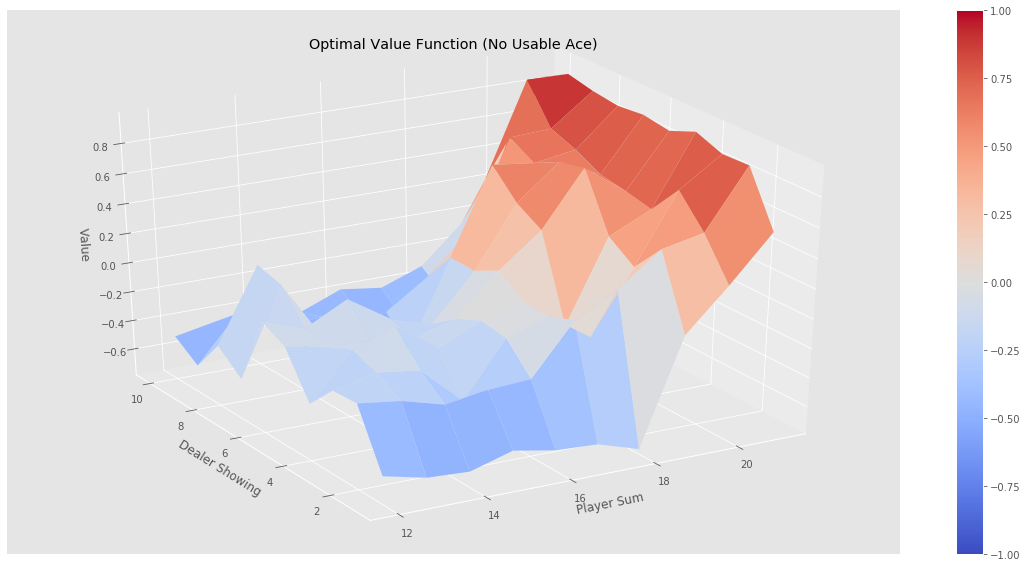

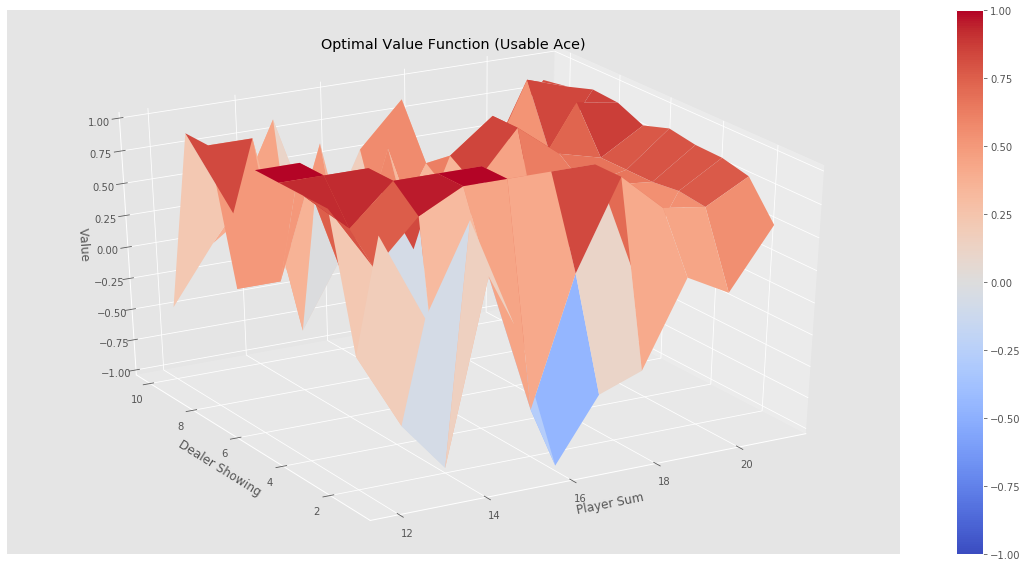

In [33]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")